#### Convex term project: ADMM-Image Denoising
#### Spring2025
#### Jingyi Wang, Yuning Zhuang

#### Notebook Introduction: 
In this notebook, ADMM-the Alternating Direction Method of Multipliers method is implemented to a TV(total variant) regularized image denoising prolem. The chosen image is the typical figure "Lena.jpg". The gaussian noises are added to the picture and ADMM is using to help denoising the noisy picture.

### 1. Set up: prepare the noisy image and helper functions

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import urllib.request
from skimage.metrics import peak_signal_noise_ratio as psnr

# --- Download and load Lena image ---
url = 'https://github.com/opencv/opencv/raw/master/samples/data/lena.jpg'
urllib.request.urlretrieve(url, 'lena.jpg')

# Load as grayscale and normalize
image3 = cv2.imread('lena.jpg', cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0

# Add Gaussian noise
np.random.seed(0)
noisy = image3 + np.random.normal(0, 0.1, image3.shape)
noisy = np.clip(noisy, 0, 1)

# --- Helper Functions ---

def grad(u):
    ux = np.zeros_like(u)
    uy = np.zeros_like(u)
    ux[:, :-1] = np.diff(u, axis=1)
    uy[:-1, :] = np.diff(u, axis=0)
    return ux, uy

def div(px, py):
    tx = np.zeros_like(px)
    ty = np.zeros_like(py)
    tx[:, 1:] = px[:, 1:] - px[:, :-1]
    ty[1:, :] = py[1:, :] - py[:-1, :]
    tx[:, 0] = px[:, 0]
    ty[0, :] = py[0, :]
    return tx + ty

def shrink(x, y, kappa):
    s = np.sqrt(x**2 + y**2)
    scale = np.maximum(s - kappa, 0) / (s + 1e-10)
    return scale * x, scale * y

def solve_u(noisy, div_pb, rho):
    m, n = noisy.shape
    wx = 2 * np.pi * np.fft.fftfreq(n)
    wy = 2 * np.pi * np.fft.fftfreq(m)
    WX, WY = np.meshgrid(wx, wy)
    denom = 1 + rho * (4 - 2 * np.cos(WX) - 2 * np.cos(WY))

    noisy_fft = np.fft.fft2(noisy)
    div_fft = np.fft.fft2(div_pb)
    u_fft = (noisy_fft + rho * div_fft) / denom
    u = np.real(np.fft.ifft2(u_fft))
    return u


### 2. ADMM-TV Denosing

In [26]:
# --- ADMM-TV Denoising ---

def tv_denoise_ADMM(noisy, original, lambd, rho, num_iter):
    u = noisy.copy()
    px = np.zeros_like(u)
    py = np.zeros_like(u)
    bx = np.zeros_like(u)
    by = np.zeros_like(u)

    psnr_history = []

    for i in range(num_iter):
        div_pb = div(px - bx, py - by)
        u = solve_u(noisy, div_pb, rho)
        ux, uy = grad(u)
        px, py = shrink(ux + bx, uy + by, lambd / rho)
        bx += ux - px
        by += uy - py
        u = np.clip(u, 0, 1)

        current_psnr = psnr(original, u, data_range=1.0)
        psnr_history.append(current_psnr)

    return u, psnr_history

#### Denoising result of implementing ADMM

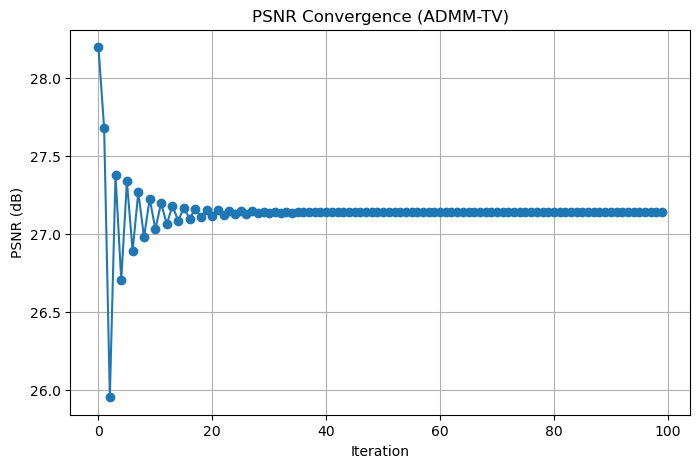

/var/folders/1b/zznb8wm940383dcw1_qxlls40000gn/T/ipykernel_94712/54820870.py:28: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  plt.title(f'Noisy\nPSNR={psnr(image3, noisy):.2f} dB')


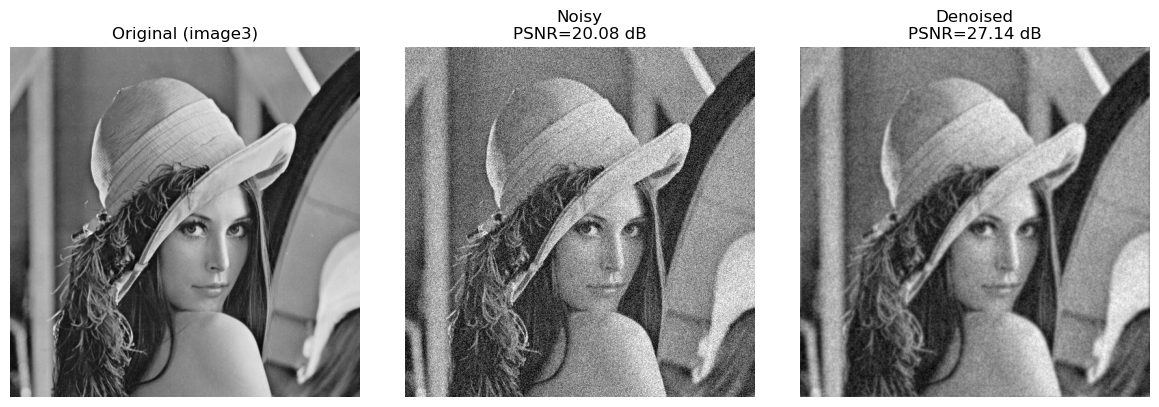

Initial PSNR (noisy): 20.08 dB
Final PSNR (denoised): 27.14 dB


/var/folders/1b/zznb8wm940383dcw1_qxlls40000gn/T/ipykernel_94712/54820870.py:40: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  print(f"Initial PSNR (noisy): {psnr(image3, noisy):.2f} dB")


In [15]:
lambd = 0.15
rho = 2.0
num_iter = 100

denoised, psnr_history = tv_denoise_ADMM(noisy, image3, lambd, rho, num_iter)

# --- Plot PSNR Curve ---

plt.figure(figsize=(8, 5))
plt.plot(psnr_history, marker='o')
plt.title('PSNR Convergence (ADMM-TV)')
plt.xlabel('Iteration')
plt.ylabel('PSNR (dB)')
plt.grid(True)
plt.show()

# --- Show Images ---
plt.figure(figsize=(12, 4))

plt.subplot(131)
plt.imshow(image3, cmap='gray')
plt.title('Original (image3)')
plt.axis('off')

plt.subplot(132)
plt.imshow(noisy, cmap='gray')
plt.title(f'Noisy\nPSNR={psnr(image3, noisy):.2f} dB')
plt.axis('off')

plt.subplot(133)
plt.imshow(denoised, cmap='gray')
plt.title(f'Denoised\nPSNR={psnr_history[-1]:.2f} dB')
plt.axis('off')

plt.tight_layout()
plt.show()

# --- Final PSNR Output ---
print(f"Initial PSNR (noisy): {psnr(image3, noisy):.2f} dB")
print(f"Final PSNR (denoised): {psnr_history[-1]:.2f} dB")


In [16]:
from skimage.metrics import structural_similarity as ssim

# Gaussian smoothing baseline
gaussian_denoised = cv2.GaussianBlur(noisy, (5, 5), sigmaX=1.0)

# Compute PSNR and SSIM
psnr_gaussian = psnr(image3, gaussian_denoised, data_range=1.0)
ssim_gaussian = ssim(image3, gaussian_denoised, data_range=1.0)
psnr_admm = psnr(image3, denoised, data_range=1.0)
ssim_admm = ssim(image3, denoised, data_range=1.0)

# Print results
print(f"[Gaussian Smoothing] PSNR: {psnr_gaussian:.2f} dB, SSIM: {ssim_gaussian:.4f}")
print(f"[ADMM-TV Denoising ] PSNR: {psnr_admm:.2f} dB, SSIM: {ssim_admm:.4f}")


[Gaussian Smoothing] PSNR: 28.86 dB, SSIM: 0.7033
[ADMM-TV Denoising ] PSNR: 27.14 dB, SSIM: 0.6407


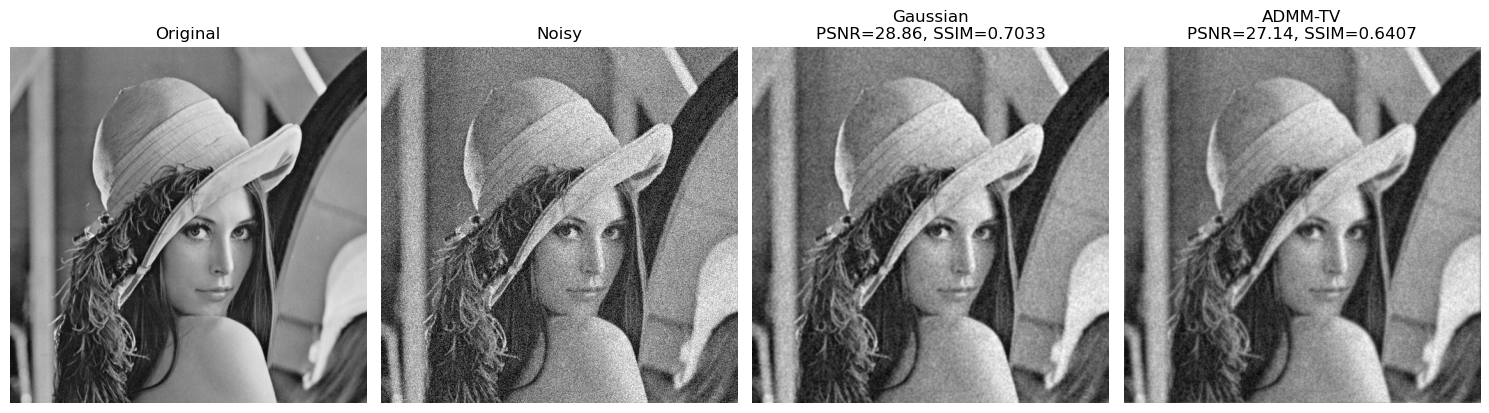

In [17]:
plt.figure(figsize=(15, 4))

plt.subplot(141)
plt.imshow(image3, cmap='gray')
plt.title("Original")
plt.axis('off')

plt.subplot(142)
plt.imshow(noisy, cmap='gray')
plt.title("Noisy")
plt.axis('off')

plt.subplot(143)
plt.imshow(gaussian_denoised, cmap='gray')
plt.title(f"Gaussian\nPSNR={psnr_gaussian:.2f}, SSIM={ssim_gaussian:.4f}")
plt.axis('off')

plt.subplot(144)
plt.imshow(denoised, cmap='gray')
plt.title(f"ADMM-TV\nPSNR={psnr_admm:.2f}, SSIM={ssim_admm:.4f}")
plt.axis('off')

plt.tight_layout()
plt.show()


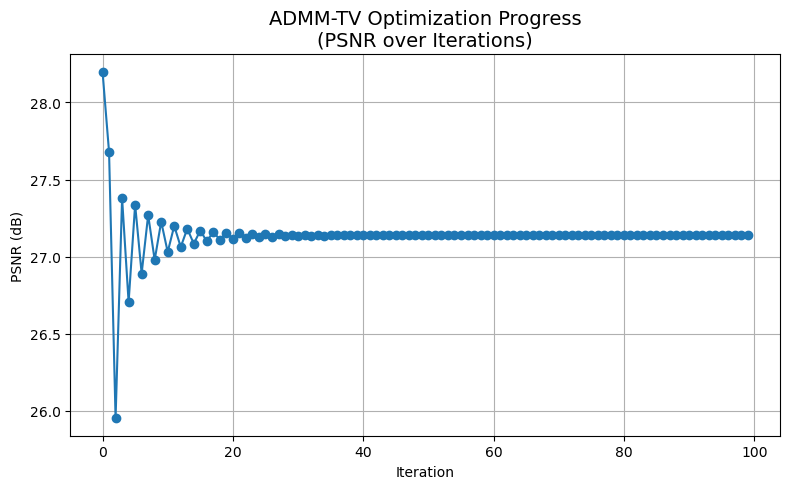

In [5]:
plt.figure(figsize=(8, 5))
plt.plot(psnr_history, marker='o')
plt.title("ADMM-TV Optimization Progress\n(PSNR over Iterations)", fontsize=14)
plt.xlabel("Iteration")
plt.ylabel("PSNR (dB)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [6]:
# remove
# Try more aggressive regularization and more iterations
# lambd = 0.2     # more noise suppression
# rho = 2.0
# num_iter = 150  # allow better convergence


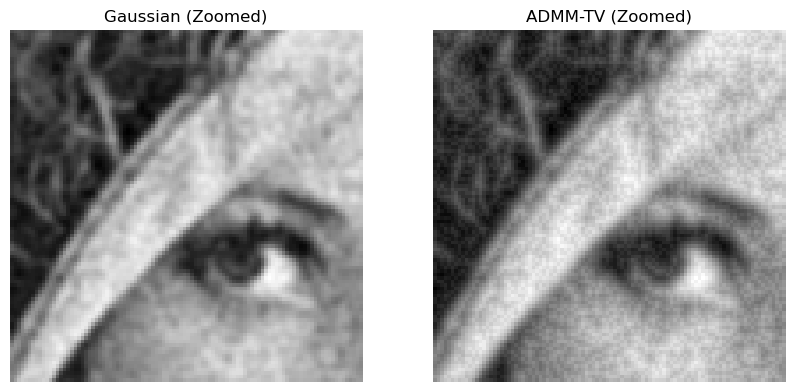

In [7]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(gaussian_denoised[200:300, 200:300], cmap='gray')
plt.title('Gaussian (Zoomed)')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(denoised[200:300, 200:300], cmap='gray')
plt.title('ADMM-TV (Zoomed)')
plt.axis('off')
plt.show()


📊 Updated Results with Tuned Parameters:
[Gaussian Smoothing] PSNR: 28.86 dB, SSIM: 0.7033
[ADMM-TV Denoising ] PSNR: 27.14 dB, SSIM: 0.6407


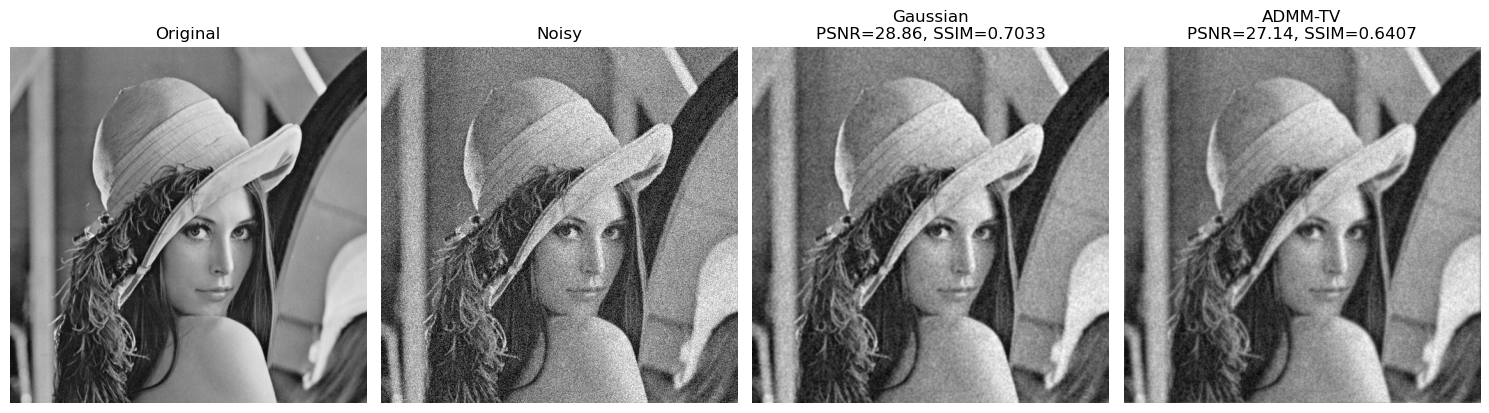

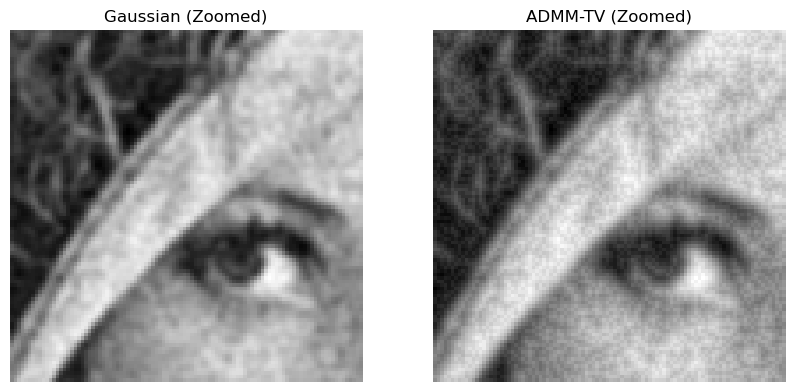

In [18]:
# --- Run ADMM-TV again with new params ---
denoised_updated, psnr_history_updated = tv_denoise_ADMM(noisy, image3, lambd, rho, num_iter)

# --- Gaussian smoothing baseline (same as before) ---
gaussian_denoised = cv2.GaussianBlur(noisy, (5, 5), sigmaX=1.0)

# --- Compute new metrics ---
psnr_gaussian = psnr(image3, gaussian_denoised, data_range=1.0)
ssim_gaussian = ssim(image3, gaussian_denoised, data_range=1.0)
psnr_admm = psnr(image3, denoised_updated, data_range=1.0)
ssim_admm = ssim(image3, denoised_updated, data_range=1.0)

# --- Print results ---
print("📊 Updated Results with Tuned Parameters:")
print(f"[Gaussian Smoothing] PSNR: {psnr_gaussian:.2f} dB, SSIM: {ssim_gaussian:.4f}")
print(f"[ADMM-TV Denoising ] PSNR: {psnr_admm:.2f} dB, SSIM: {ssim_admm:.4f}")

# --- Visual Comparison ---
plt.figure(figsize=(15, 4))

plt.subplot(141)
plt.imshow(image3, cmap='gray')
plt.title("Original")
plt.axis('off')

plt.subplot(142)
plt.imshow(noisy, cmap='gray')
plt.title("Noisy")
plt.axis('off')

plt.subplot(143)
plt.imshow(gaussian_denoised, cmap='gray')
plt.title(f"Gaussian\nPSNR={psnr_gaussian:.2f}, SSIM={ssim_gaussian:.4f}")
plt.axis('off')

plt.subplot(144)
plt.imshow(denoised_updated, cmap='gray')
plt.title(f"ADMM-TV\nPSNR={psnr_admm:.2f}, SSIM={ssim_admm:.4f}")
plt.axis('off')

plt.tight_layout()
plt.show()

# --- Zoom in on edge region (optional) ---
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(gaussian_denoised[200:300, 200:300], cmap='gray')
plt.title('Gaussian (Zoomed)')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(denoised_updated[200:300, 200:300], cmap='gray')
plt.title('ADMM-TV (Zoomed)')
plt.axis('off')
plt.show()


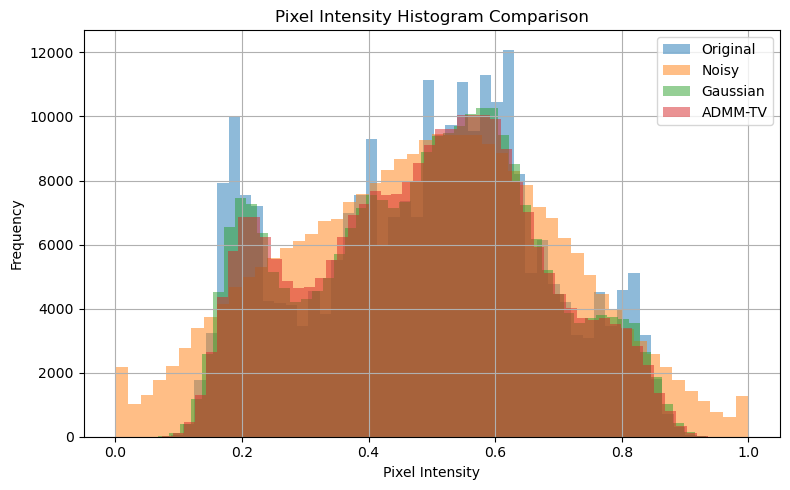

In [21]:
plt.figure(figsize=(8, 5))
plt.hist(image3.ravel(), bins=50, alpha=0.5, label='Original')
plt.hist(noisy.ravel(), bins=50, alpha=0.5, label='Noisy')
plt.hist(gaussian_denoised.ravel(), bins=50, alpha=0.5, label='Gaussian')
plt.hist(denoised_updated.ravel(), bins=50, alpha=0.5, label='ADMM-TV')
plt.title("Pixel Intensity Histogram Comparison")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


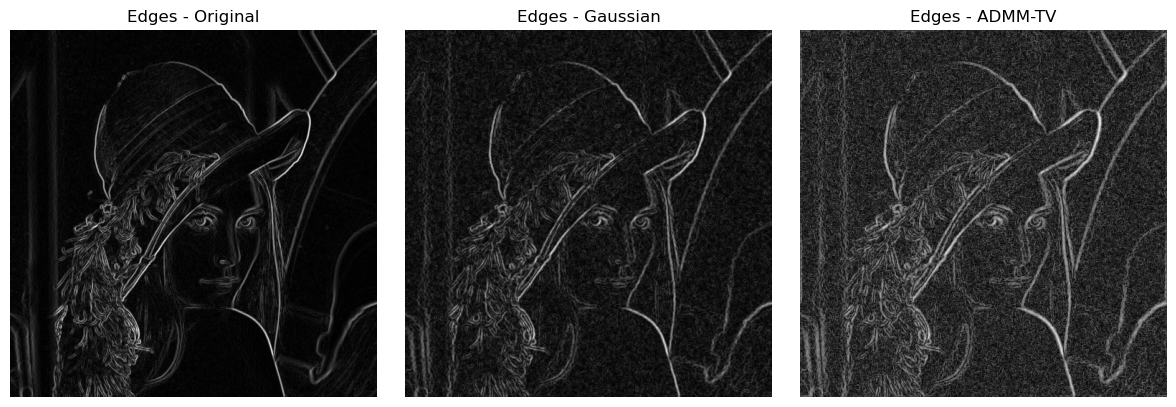

In [12]:
from skimage.filters import sobel

edge_orig = sobel(image3)
edge_gaussian = sobel(gaussian_denoised)
edge_admm = sobel(denoised_updated)

plt.figure(figsize=(12, 4))

plt.subplot(131)
plt.imshow(edge_orig, cmap='gray')
plt.title("Edges - Original")
plt.axis('off')

plt.subplot(132)
plt.imshow(edge_gaussian, cmap='gray')
plt.title("Edges - Gaussian")
plt.axis('off')

plt.subplot(133)
plt.imshow(edge_admm, cmap='gray')
plt.title("Edges - ADMM-TV")
plt.axis('off')

plt.tight_layout()
plt.show()


In [22]:
from scipy.ndimage import median_filter

median_denoised = median_filter(noisy, size=3)

psnr_median = psnr(image3, median_denoised, data_range=1.0)
ssim_median = ssim(image3, median_denoised, data_range=1.0)

print(f"[Median Filter] PSNR: {psnr_median:.2f} dB, SSIM: {ssim_median:.4f}")


[Median Filter] PSNR: 26.77 dB, SSIM: 0.5741


In [23]:

def grad_img(u):
    ux = np.zeros_like(u)
    uy = np.zeros_like(u)
    ux[:, :-1] = np.diff(u, axis=1)
    uy[:-1, :] = np.diff(u, axis=0)
    return ux, uy

def div_img(px, py):
    tx = np.zeros_like(px)
    ty = np.zeros_like(py)
    tx[:, 1:] = px[:, 1:] - px[:, :-1]
    ty[1:, :] = py[1:, :] - py[:-1, :]
    tx[:, 0] = px[:, 0]
    ty[0, :] = py[0, :]
    return tx + ty

#  FIXED prox_tv using Chambolle's algorithm
def prox_tv(u, lmbd, n_iter=30):
    m, n = u.shape
    px = np.zeros_like(u)
    py = np.zeros_like(u)
    taut = 0.125  # step size for projection

    for _ in range(n_iter):
        div_p = div_img(px, py)
        dx, dy = grad_img(div_p - u / lmbd)
        norm = np.maximum(1.0, np.sqrt(dx**2 + dy**2))
        px = (px + taut * dx) / norm
        py = (py + taut * dy) / norm

    return u - lmbd * div_img(px, py)

# FISTA-TV with fixed prox
def fista_tv_denoising(f, lmbd=0.15, step=0.25, n_iter=100, original=None):
    x = f.copy()
    y = f.copy()
    t = 1
    psnr_list = []

    for i in range(n_iter):
        grad = y - f
        x_new = prox_tv(y - step * grad, lmbd * step)
        x_new = np.clip(x_new, 0, 1)

        t_new = (1 + np.sqrt(1 + 4 * t**2)) / 2
        y = x_new + ((t - 1) / t_new) * (x_new - x)

        x = x_new
        t = t_new

        if original is not None:
            psnr_list.append(psnr(original, x, data_range=1.0))

    return x, psnr_list


In [27]:
denoised_fista, psnr_fista = fista_tv_denoising(noisy, lmbd=0.15, step=0.25, n_iter=100, original=image3)
# Run ADMM-TV (from earlier)
#denoised_admm, psnr_admm = tv_denoise_ADMM(noisy, image3, lambd=0.15, rho=2.0, num_iter=100)
denoised_admm, psnr_admm = tv_denoise_ADMM(noisy, image3, 0.15, 2.0, 100)

print(f"[ADMM-TV ] PSNR: {psnr_admm[-1]:.2f}")
print(f"[FISTA-TV] PSNR: {psnr_fista[-1]:.2f}")


[ADMM-TV ] PSNR: 27.14
[FISTA-TV] PSNR: 25.72


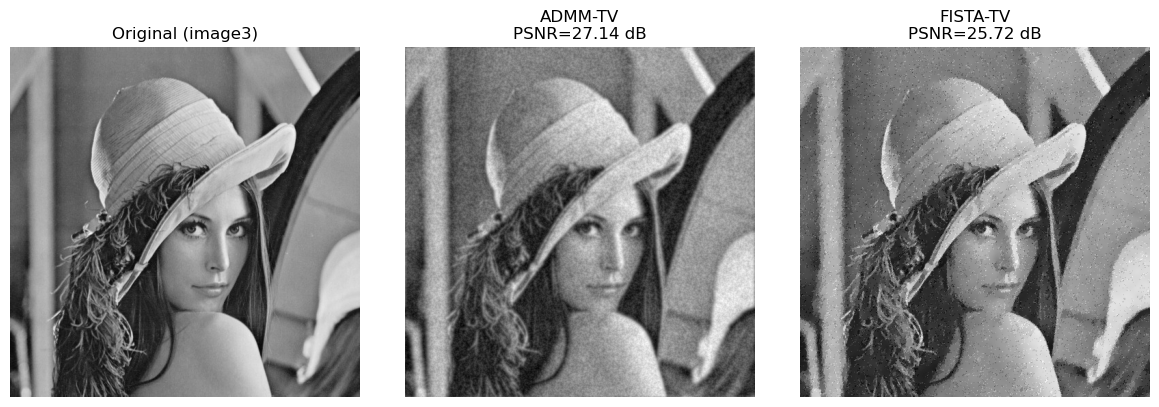

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(131)
plt.imshow(image3, cmap='gray')
plt.title("Original (image3)")
plt.axis('off')

plt.subplot(132)
plt.imshow(denoised_admm, cmap='gray')
plt.title(f"ADMM-TV\nPSNR={psnr_admm[-1]:.2f} dB")
plt.axis('off')

plt.subplot(133)
plt.imshow(denoised_fista, cmap='gray')
plt.title(f"FISTA-TV\nPSNR={psnr_fista[-1]:.2f} dB")
plt.axis('off')

plt.tight_layout()
plt.show()


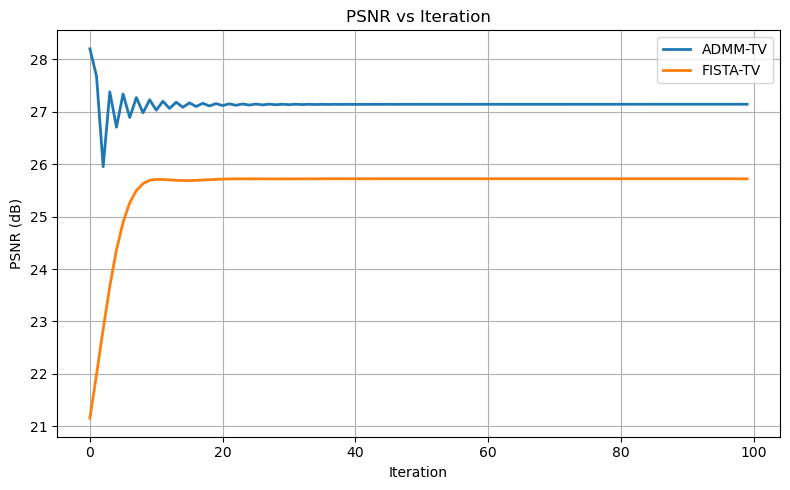

In [29]:
plt.figure(figsize=(8, 5))
plt.plot(psnr_admm, label="ADMM-TV", linewidth=2)
plt.plot(psnr_fista, label="FISTA-TV", linewidth=2)
plt.title("PSNR vs Iteration")
plt.xlabel("Iteration")
plt.ylabel("PSNR (dB)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [30]:
from skimage.metrics import structural_similarity as ssim

ssim_admm = ssim(image3, denoised_admm, data_range=1.0)
ssim_fista = ssim(image3, denoised_fista, data_range=1.0)

print(f"[ADMM-TV ] SSIM: {ssim_admm:.4f}")
print(f"[FISTA-TV] SSIM: {ssim_fista:.4f}")


[ADMM-TV ] SSIM: 0.6407
[FISTA-TV] SSIM: 0.5455


In [31]:
# Run ADMM-TV (from earlier)
denoised_admm, psnr_admm = tv_denoise_ADMM(noisy, image3, lambd=0.15, rho=2.0, num_iter=100)

# Run FISTA-TV
denoised_fista, psnr_fista = fista_tv_denoising(noisy, lmbd=0.15, step=0.25, n_iter=100)
